# Trabajo Práctico Nº1

**Integrantes**:
- Carolina Perez Omodeo
- Emiliano Uriel Martino
- Alan Perez Winter

**Objetivos**:

**Parte 1** (imágenes en /white_patch y /coord_cromaticas):
1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.
2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.

**Parte 2**:
1. Para las imágenes ``img1_tp.png`` y ``img2_tp.png`` leerlas con OpenCV en escala de grisas y visualizarlas. 
2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?
3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture

### Coordenadas cromáticas

In [2]:
def get_chroma_coords(img, to_RGB=True):
    if to_RGB:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)    # BGR to RGB
    img = img / 255.0                               # 0-255 to 0-1
    X = img[..., 0]                                 # get X channel
    Y = img[..., 1]                                 # get Y channel
    Z = img[..., 2]                                 # get Z channel
    sum_XYZ = X + Y + Z                             # sum of X, Y and Z
    x = np.divide(X, sum_XYZ, out=np.zeros_like(X), where=sum_XYZ != 0)
    y = np.divide(Y, sum_XYZ, out=np.zeros_like(Y), where=sum_XYZ != 0)
    z = 1.0 - x - y
    z = np.where(z < 0, 0, z)
    img_cc = cv.merge((x, y, z))                    # merge x, y and z channels
    img_cc = cv.multiply(img_cc, 255.0)             # 0-1 to 0-255
    img_cc = np.round(img_cc).astype(np.uint8)      # round and convert to uint8
    
    return img_cc

In [3]:
PATH_CC1 = "coord_cromaticas/CoordCrom_1.png"
PATH_CC2 = "coord_cromaticas/CoordCrom_2.png"
PATH_CC3 = "coord_cromaticas/CoordCrom_3.png"

In [4]:
img_cc1 = cv.imread(PATH_CC1, cv.IMREAD_COLOR)
img_cc2 = cv.imread(PATH_CC2, cv.IMREAD_COLOR)
img_cc3 = cv.imread(PATH_CC3, cv.IMREAD_COLOR)

print("Imagen 1:", img_cc1.shape, "pixels")
print("Imagen 2:", img_cc2.shape, "pixels")
print("Imagen 3:", img_cc3.shape, "pixels")

Imagen 1: (996, 908, 3) pixels
Imagen 2: (996, 908, 3) pixels
Imagen 3: (996, 908, 3) pixels


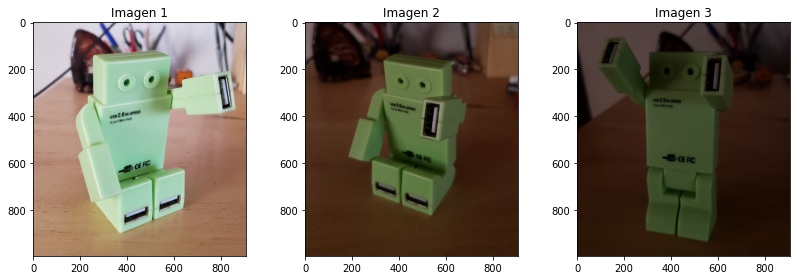

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img_cc1[..., ::-1])
axs[0].set_title("Imagen 1")
axs[1].imshow(img_cc2[..., ::-1])
axs[1].set_title("Imagen 2")
axs[2].imshow(img_cc3[..., ::-1])
axs[2].set_title("Imagen 3")
fig.set_tight_layout(True)
plt.savefig("coord_cromaticas_org.png")
plt.show()

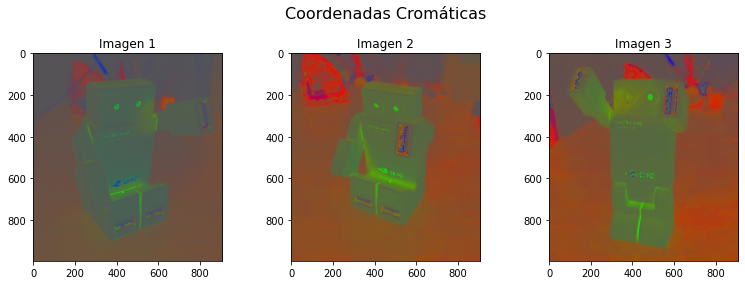

In [6]:
img1_to_cc = get_chroma_coords(img_cc1)
img2_to_cc = get_chroma_coords(img_cc2)
img3_to_cc = get_chroma_coords(img_cc3)

# plot three images in subplots horizontally
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img1_to_cc)
axs[0].set_title("Imagen 1")
axs[1].imshow(img2_to_cc)
axs[1].set_title("Imagen 2")
axs[2].imshow(img3_to_cc)
axs[2].set_title("Imagen 3")
fig.set_tight_layout(True)
fig.suptitle("Coordenadas Cromáticas", fontsize=16)
plt.savefig("coord_cromaticas.png")
plt.show()

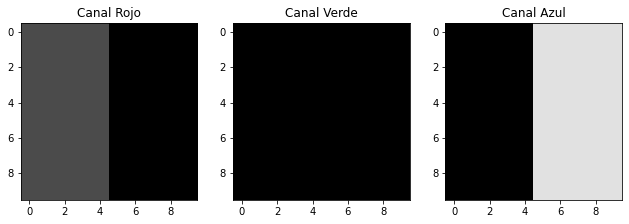

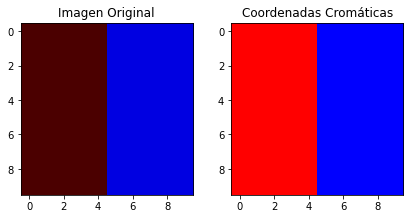

In [7]:
# Let's create an image half blue and half red
img_half = np.zeros((10, 10, 3), dtype=np.uint8)
img_half[:, :5, 0] = 50
img_half[:, 5:, 2] = 150
img_half = cv.multiply(img_half, 1.5)
img_half_cc = get_chroma_coords(img_half, to_RGB=False)
R, G, B = cv.split(img_half)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Canal Rojo")
axs[1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Canal Verde")
axs[2].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Canal Azul")
fig.set_tight_layout(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img_half)
axs[0].set_title("Imagen Original")
axs[1].imshow(img_half_cc)
axs[1].set_title("Coordenadas Cromáticas")
fig.set_tight_layout(True)
plt.show()

### White Patch

In [8]:
def get_white_patch(img):
    shape = img.shape[:2]                           # get shape of image
    img_wp = (img.copy()).astype(np.float64)        # copy image
    B, G, R = cv.split(img_wp)                      # split B, G and R channels
    maxB, maxG, maxR = np.max(img, axis=(0, 1))     # get max values of B, G and R
    maxB = maxB * np.ones(shape)    # create a matrix with maxB in all elements
    maxG = maxG * np.ones(shape)    # create a matrix with maxG in all elements
    maxR = maxR * np.ones(shape)    # create a matrix with maxR in all elements
    B = np.divide(B, maxB, out=np.zeros_like(B), where=maxB != 0) # normalize B channel
    G = np.divide(G, maxG, out=np.zeros_like(G), where=maxG != 0) # normalize G channel
    R = np.divide(R, maxR, out=np.zeros_like(R), where=maxR != 0) # normalize R channel
    img_wp = cv.merge((B, G, R))                    # merge B, G and R channels
    img_wp = cv.multiply(img_wp, 255.0)             # 0-1 to 0-255
    img_wp = np.round(img_wp).astype(np.uint8)      # round and convert to uint8
    
    return img_wp

In [9]:
PATH_TEST_BLUE = "white_patch/test_blue.png"
PATH_TEST_RED = "white_patch/test_red.png"
PATH_TEST_GREEN = "white_patch/test_green.png"
PATH_WP_BLUE = "white_patch/wp_blue.jpg"
PATH_WP_RED = "white_patch/wp_red.png"
PATH_WP_RED2 = "white_patch/wp_red2.jpg"
PATH_WP_GREEN = "white_patch/wp_green.png"
PATH_WP_GREEN2 = "white_patch/wp_green2.jpg"

In [10]:
img_test_blue = cv.imread(PATH_TEST_BLUE, cv.IMREAD_COLOR)
img_test_red = cv.imread(PATH_TEST_RED, cv.IMREAD_COLOR)
img_test_green = cv.imread(PATH_TEST_GREEN, cv.IMREAD_COLOR)
img_wp_blue = cv.imread(PATH_WP_BLUE, cv.IMREAD_COLOR)
img_wp_red = cv.imread(PATH_WP_RED, cv.IMREAD_COLOR)
img_wp_red2 = cv.imread(PATH_WP_RED2, cv.IMREAD_COLOR)
img_wp_green = cv.imread(PATH_WP_GREEN, cv.IMREAD_COLOR)
img_wp_green2 = cv.imread(PATH_WP_GREEN2, cv.IMREAD_COLOR)

#### Prueba sobre manos

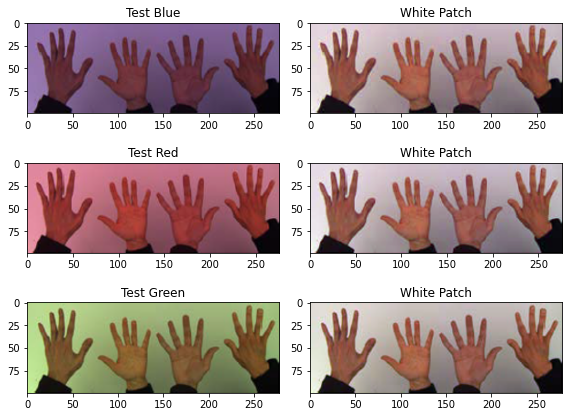

In [11]:
img_test_blue_wp = get_white_patch(img_test_blue)
img_test_red_wp = get_white_patch(img_test_red)
img_test_green_wp = get_white_patch(img_test_green)


fig, axs = plt.subplots(3, 2, figsize=(8, 6))
axs[0,0].imshow(img_test_blue[..., ::-1])
axs[0,0].set_title("Test Blue")
axs[0,1].imshow(img_test_blue_wp[..., ::-1])
axs[0,1].set_title("White Patch")

axs[1,0].imshow(img_test_red[..., ::-1])
axs[1,0].set_title("Test Red")
axs[1,1].imshow(img_test_red_wp[..., ::-1])
axs[1,1].set_title("White Patch")

axs[2,0].imshow(img_test_green[..., ::-1])
axs[2,0].set_title("Test Green")
axs[2,1].imshow(img_test_green_wp[..., ::-1])
axs[2,1].set_title("White Patch")

fig.set_tight_layout(True)
plt.savefig("white_patch_test.png")
plt.show()

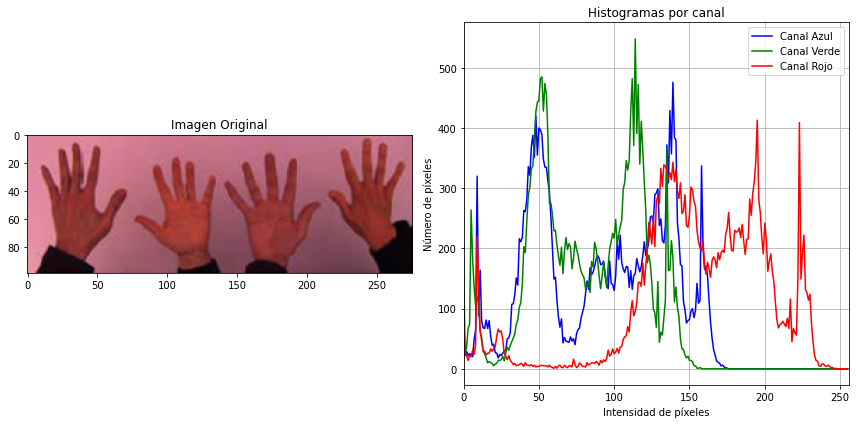

In [12]:
B, G, R = cv.split(img_test_red)
hist_B = cv.calcHist([B], [0], None, [256], [0, 256], accumulate=False)
hist_G = cv.calcHist([G], [0], None, [256], [0, 256], accumulate=False)
hist_R = cv.calcHist([R], [0], None, [256], [0, 256], accumulate=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(img_test_red[..., ::-1])
axs[0].set_title("Imagen Original")

axs[1].plot(hist_B, color='blue', label='Canal Azul')
axs[1].plot(hist_G, color='green', label='Canal Verde')
axs[1].plot(hist_R, color='red', label='Canal Rojo')
axs[1].set_xlim([0, 256])
axs[1].set_title("Histogramas por canal")
axs[1].set_xlabel("Intensidad de píxeles")
axs[1].set_ylabel("Número de píxeles")
axs[1].legend()
axs[1].grid()

fig.set_tight_layout(True)
plt.savefig("wp_test_red_hist.png")
plt.show()

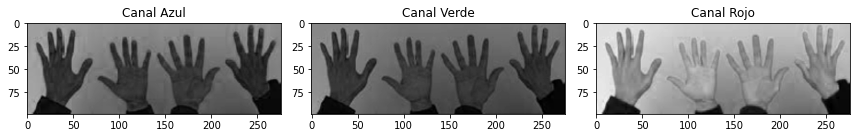

In [13]:
# split image into 3 channels
B, G, R = cv.split(img_test_red)
# plot 3 channels
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Canal Azul")
axs[1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Canal Verde")
axs[2].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Canal Rojo")
fig.set_tight_layout(True)
plt.savefig("test_red_channels.png")
plt.show()

In [14]:
print("Imagen Test Red:")
print("Canal Azul: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(B), np.mean(B), np.std(B)))
print("Canal Verde: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(G), np.mean(G), np.std(G)))
print("Canal Rojo: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(R), np.mean(R), np.std(R)))

Imagen Test Red:
Canal Azul: Max=175.00	Mean=91.17	Sigma=44.00
Canal Verde: Max=157.00	Mean=81.10	Sigma=35.64
Canal Rojo: Max=247.00	Mean=155.84	Sigma=47.48


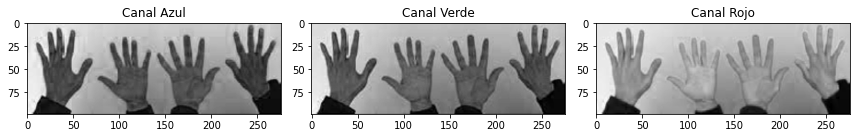

In [15]:
# split image into 3 channels
B, G, R = cv.split(img_test_red_wp)
# plot 3 channels
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Canal Azul")
axs[1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Canal Verde")
axs[2].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Canal Rojo")
fig.set_tight_layout(True)
plt.savefig("test_red_wp_channels.png")
plt.show()

In [16]:
print("Imagen Test Red Withe Patch:")
print("Canal Azul: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(B), np.mean(B), np.std(B)))
print("Canal Verde: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(G), np.mean(G), np.std(G)))
print("Canal Rojo: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(R), np.mean(R), np.std(R)))

Imagen Test Red Withe Patch:
Canal Azul: Max=255.00	Mean=132.86	Sigma=64.13
Canal Verde: Max=255.00	Mean=131.72	Sigma=57.91
Canal Rojo: Max=255.00	Mean=160.87	Sigma=49.00


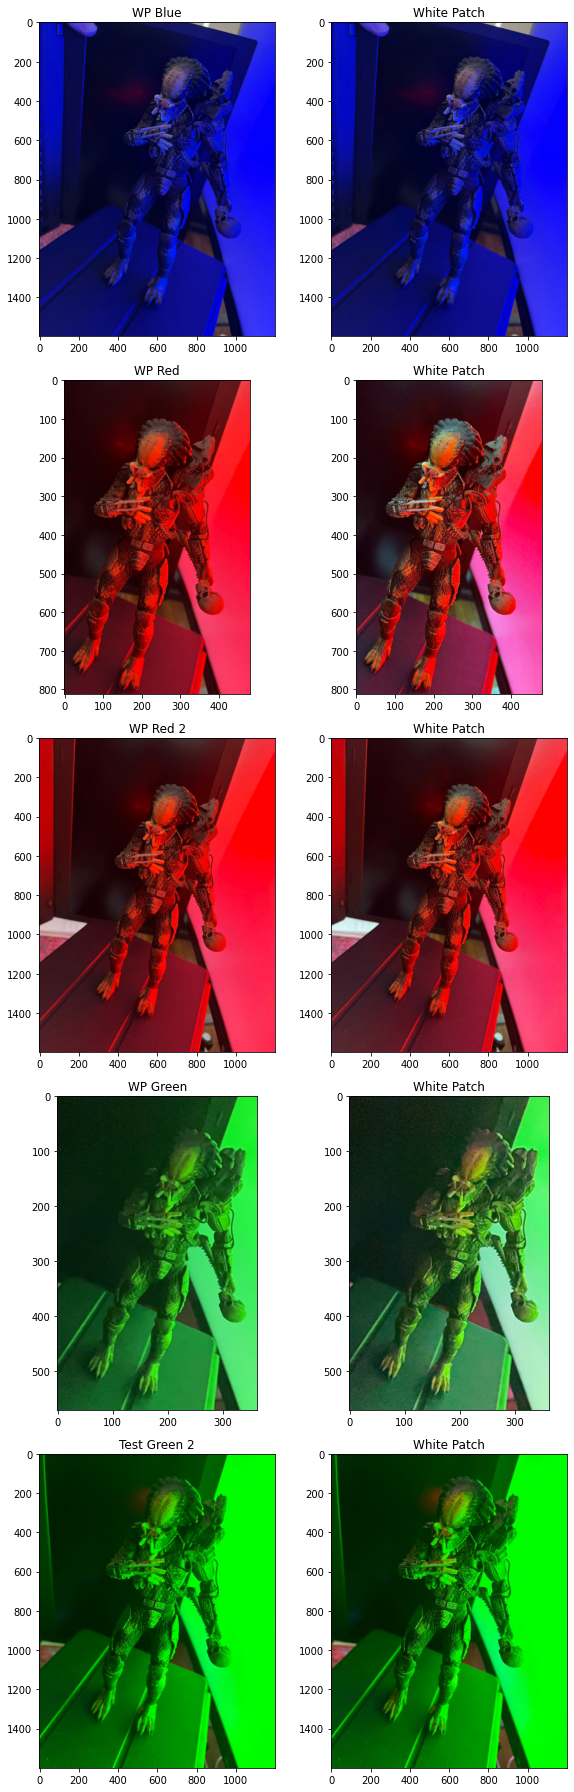

In [17]:
img_wp_blue_wp = get_white_patch(img_wp_blue)
img_wp_red_wp = get_white_patch(img_wp_red)
img_wp_red2_wp = get_white_patch(img_wp_red2)
img_wp_green_wp = get_white_patch(img_wp_green)
img_wp_green2_wp = get_white_patch(img_wp_green2)

fig, axs = plt.subplots(5, 2, figsize=(10, 25))

axs[0,0].imshow(img_wp_blue[..., ::-1])
axs[0,0].set_title("WP Blue")
axs[0,1].imshow(img_wp_blue_wp[..., ::-1])
axs[0,1].set_title("White Patch")

axs[1,0].imshow(img_wp_red[..., ::-1])
axs[1,0].set_title("WP Red")
axs[1,1].imshow(img_wp_red_wp[..., ::-1])
axs[1,1].set_title("White Patch")

axs[2,0].imshow(img_wp_red2[..., ::-1])
axs[2,0].set_title("WP Red 2")
axs[2,1].imshow(img_wp_red2_wp[..., ::-1])
axs[2,1].set_title("White Patch")

axs[3,0].imshow(img_wp_green[..., ::-1])
axs[3,0].set_title("WP Green")
axs[3,1].imshow(img_wp_green_wp[..., ::-1])
axs[3,1].set_title("White Patch")

axs[4,0].imshow(img_wp_green2[..., ::-1])
axs[4,0].set_title("Test Green 2")
axs[4,1].imshow(img_wp_green2_wp[..., ::-1])
axs[4,1].set_title("White Patch")

fig.set_tight_layout(True)
plt.savefig("white_patch_wp.png")
plt.show()

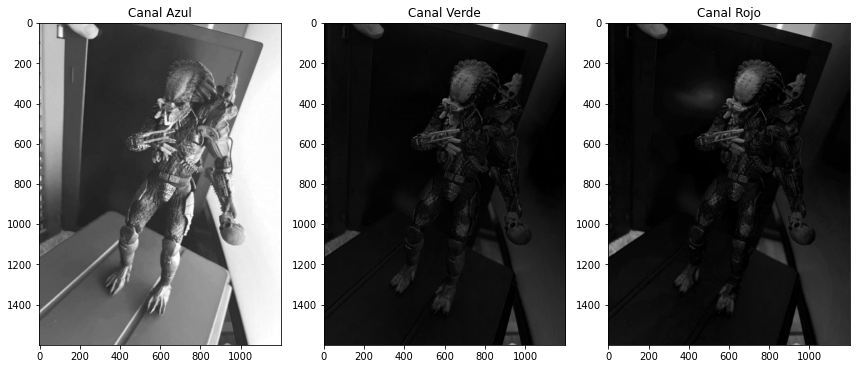

In [18]:
# split image into 3 channels
B, G, R = cv.split(img_wp_blue)
# plot 3 channels
fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Canal Azul")
axs[1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Canal Verde")
axs[2].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Canal Rojo")
fig.set_tight_layout(True)
plt.savefig("wp_blue_channels.png")
plt.show()

In [19]:
print("Media de los canales de la imagen WP Blue:")
print("Canal Azul: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(B), np.mean(B), np.std(B)))
print("Canal Verde: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(G), np.mean(G), np.std(G)))
print("Canal Rojo: Max={:.2f}\tMean={:.2f}\tSigma={:.2f}".format(np.max(R), np.mean(R), np.std(R)))

Media de los canales de la imagen WP Blue:
Canal Azul: Max=255.00	Mean=121.49	Sigma=72.45
Canal Verde: Max=255.00	Mean=17.13	Sigma=19.20
Canal Rojo: Max=255.00	Mean=17.57	Sigma=22.08


La imagen dominada por el azul tiene componentes en rojo y verde. Sin embargo, las partes R y G son de muy baja intensidad (17 in avg). El algoritmo *white patch* normaliza al maximo de los pixeles. Basta con que haya un pixel de 255 para que los colores R y G se mantengan en la misma escala. Luego el B se sigue manteniendo igual y por ende la imagen también. Aquí no presenta ventaja usar el algoritmo *white patch*. Nuestro ejemplo hackea el algoritmo, coincide con su punto débil, por lo que no resulta útil.

In [20]:
N = 100
img = np.zeros((N, N, 3), dtype=np.uint8)
for i in range(N):
    for j in range(N):
        img[i, j, 0] = 100 * i/N
img = np.round(img).astype(np.uint8)

img_wp = get_white_patch(img)

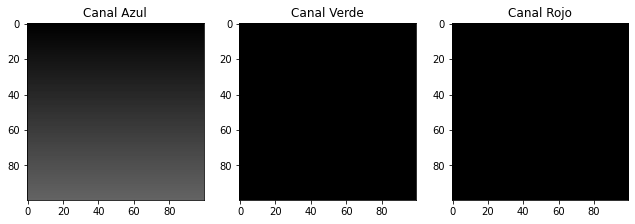

In [21]:
B, G, R = cv.split(img)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Canal Azul")
axs[1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Canal Verde")
axs[2].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Canal Rojo")
fig.set_tight_layout(True)
plt.show()

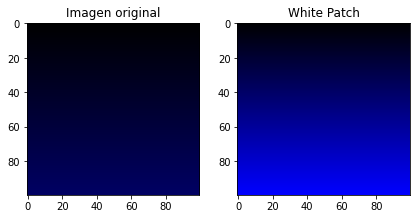

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img[..., ::-1])
axs[0].set_title("Imagen original")
axs[1].imshow(img_wp[..., ::-1])
axs[1].set_title("White Patch")
fig.set_tight_layout(True)
plt.show()

In [23]:
N = 100
img = np.zeros((N, N, 3), dtype=np.uint8)
for i in range(N):
    for j in range(N):
        img[i, j, 0] = 100 * i/N
img[:10, :, 0] = 200 * np.ones((10, N), dtype=np.uint8)
img[:10, :, 1] = 200 * np.ones((10, N), dtype=np.uint8)
img[:10, :, 2] = 200 * np.ones((10, N), dtype=np.uint8)
img = np.round(img).astype(np.uint8)

img_wp = get_white_patch(img)

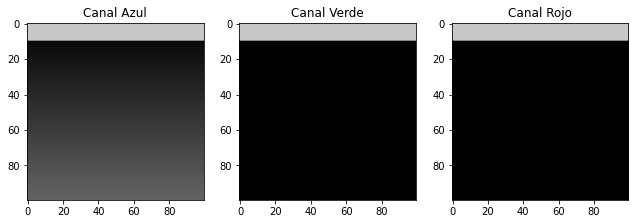

In [24]:
# split image into 3 channels
B, G, R = cv.split(img)
# plot 3 channels
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
axs[0].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Canal Azul")
axs[1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Canal Verde")
axs[2].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[2].set_title("Canal Rojo")
fig.set_tight_layout(True)
plt.show()

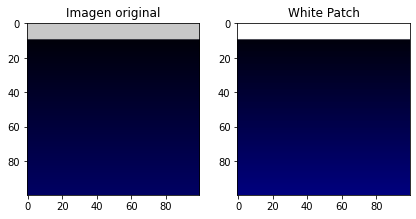

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img[..., ::-1])
axs[0].set_title("Imagen original")
axs[1].imshow(img_wp[..., ::-1])
axs[1].set_title("White Patch")
fig.set_tight_layout(True)
plt.show()

## PARTE 2

In [26]:
PATH_IMG_1 = "img1_tp.png"
PATH_IMG_2 = "img2_tp.png"
PATH_IMG_SEGMENTATION = "segmentacion.png"

In [27]:
img1 = cv.imread(PATH_IMG_1, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(PATH_IMG_2, cv.IMREAD_GRAYSCALE)

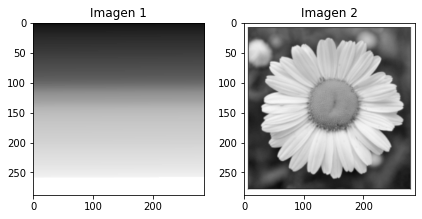

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(img1, cmap='gray')
axs[0].set_title("Imagen 1")
axs[1].imshow(img2, cmap='gray')
axs[1].set_title("Imagen 2")
fig.set_tight_layout(True)
plt.show()

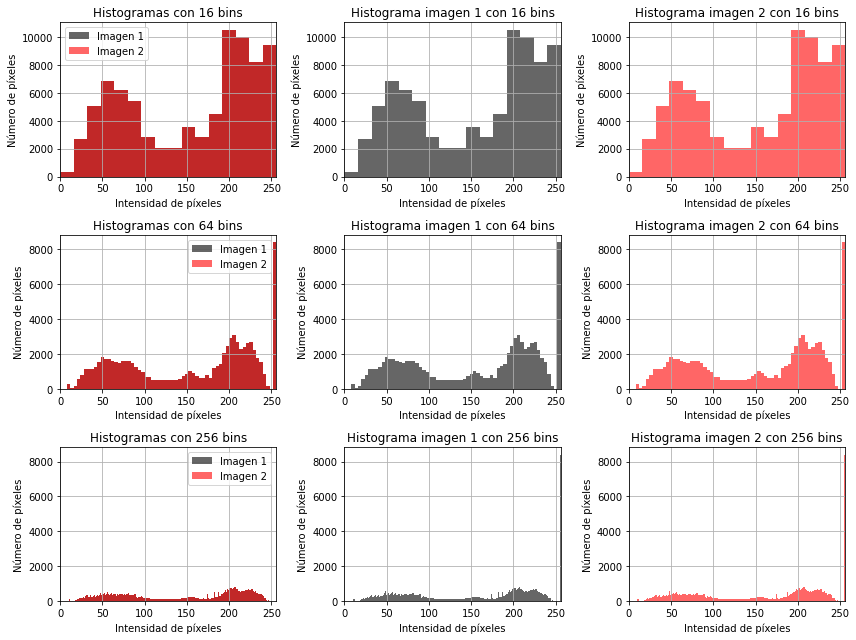

In [29]:
n_bins = [16, 64, 256]

fig, axs = plt.subplots(3, 3, figsize=(12, 9))
for i, n_bins_i in enumerate(n_bins):
    bin_width = 256 // n_bins_i
    bin_edges = np.arange(0, 256, bin_width)
    hist_img1 = cv.calcHist([img1], [0], None, [n_bins_i], [0, 256], accumulate=False)
    hist_img2 = cv.calcHist([img2], [0], None, [n_bins_i], [0, 256], accumulate=False)

    axs[i,0].bar(bin_edges, hist_img1[:, 0], width=bin_width, align='edge', color='k', alpha=0.6, label='Imagen 1')
    axs[i,0].bar(bin_edges, hist_img2[:, 0], width=bin_width, align='edge', color='r', alpha=0.6, label='Imagen 2')
    axs[i,0].set_xlim([0, 256])
    axs[i,0].set_title("Histogramas con {} bins".format(n_bins_i))
    axs[i,0].set_xlabel("Intensidad de píxeles")
    axs[i,0].set_ylabel("Número de píxeles")
    axs[i,0].legend()
    axs[i,0].grid()

    axs[i,1].bar(bin_edges, hist_img1[:, 0], width=bin_width, align='edge', color='k', alpha=0.6)
    axs[i,1].set_xlim([0, 256])
    axs[i,1].set_title("Histograma imagen 1 con {} bins".format(n_bins_i))
    axs[i,1].set_xlabel("Intensidad de píxeles")
    axs[i,1].set_ylabel("Número de píxeles")
    axs[i,1].grid()

    axs[i,2].bar(bin_edges, hist_img2[:, 0], width=bin_width, align='edge', color='r', alpha=0.6)
    axs[i,2].set_xlim([0, 256])
    axs[i,2].set_title("Histograma imagen 2 con {} bins".format(n_bins_i))
    axs[i,2].set_xlabel("Intensidad de píxeles")
    axs[i,2].set_ylabel("Número de píxeles")
    axs[i,2].grid()

fig.set_tight_layout(True)
plt.savefig("histogramas.png")
plt.show()

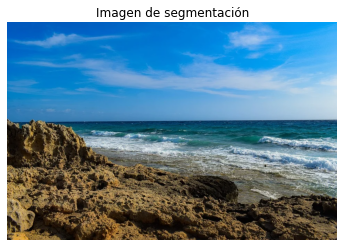

In [30]:
img_seg = cv.imread(PATH_IMG_SEGMENTATION, cv.IMREAD_COLOR)

plt.imshow(img_seg[..., ::-1])
plt.title("Imagen de segmentación")
plt.axis('off')
plt.show()

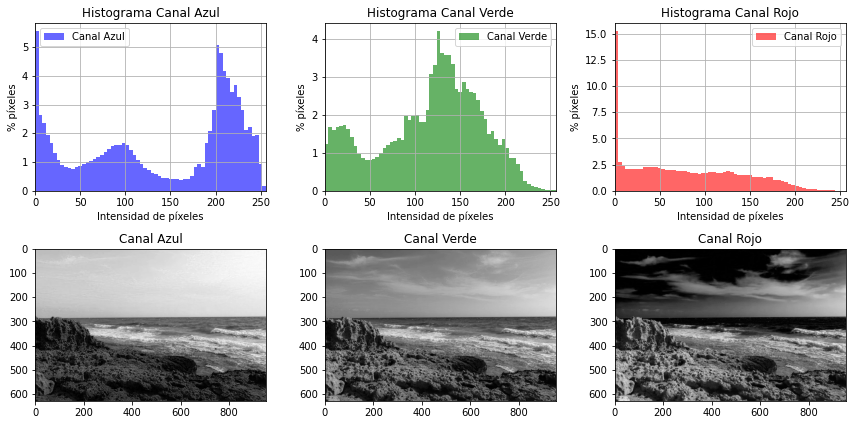

In [31]:
B, G, R = cv.split(img_seg)

n_bins = 64
bin_width = 256 // n_bins
bin_edges = np.arange(0, 256, bin_width)

hist_seg_B = cv.calcHist([B], [0], None, [n_bins], [0, 256], accumulate=False)
hist_seg_G = cv.calcHist([G], [0], None, [n_bins], [0, 256], accumulate=False)
hist_seg_R = cv.calcHist([R], [0], None, [n_bins], [0, 256], accumulate=False)

# normalize histograms
hist_seg_B = 100 * hist_seg_B / np.sum(hist_seg_B)
hist_seg_G = 100 * hist_seg_G / np.sum(hist_seg_G)
hist_seg_R = 100 * hist_seg_R / np.sum(hist_seg_R)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))

axs[0,0].bar(bin_edges, hist_seg_B[:, 0], width=bin_width, align='edge', color='b', alpha=0.6, label='Canal Azul')
axs[0,0].set_xlim([0, 256])
axs[0,0].set_title("Histograma Canal Azul")
axs[0,0].set_xlabel("Intensidad de píxeles")
axs[0,0].set_ylabel("% píxeles")
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].bar(bin_edges, hist_seg_G[:, 0], width=bin_width, align='edge', color='g', alpha=0.6, label='Canal Verde')
axs[0,1].set_xlim([0, 256])
axs[0,1].set_title("Histograma Canal Verde")
axs[0,1].set_xlabel("Intensidad de píxeles")
axs[0,1].set_ylabel("% píxeles")
axs[0,1].legend()
axs[0,1].grid()

axs[0,2].bar(bin_edges, hist_seg_R[:, 0], width=bin_width, align='edge', color='r', alpha=0.6, label='Canal Rojo')
axs[0,2].set_xlim([0, 256])
axs[0,2].set_title("Histograma Canal Rojo")
axs[0,2].set_xlabel("Intensidad de píxeles")
axs[0,2].set_ylabel("% píxeles")
axs[0,2].legend()
axs[0,2].grid()

axs[1,0].imshow(B, cmap='gray', vmin=0, vmax=255)
axs[1,0].set_title("Canal Azul")
axs[1,1].imshow(G, cmap='gray', vmin=0, vmax=255)
axs[1,1].set_title("Canal Verde")
axs[1,2].imshow(R, cmap='gray', vmin=0, vmax=255)
axs[1,2].set_title("Canal Rojo")

fig.set_tight_layout(True)
plt.savefig("histograma_bgr_segmentacion.png")
plt.show()

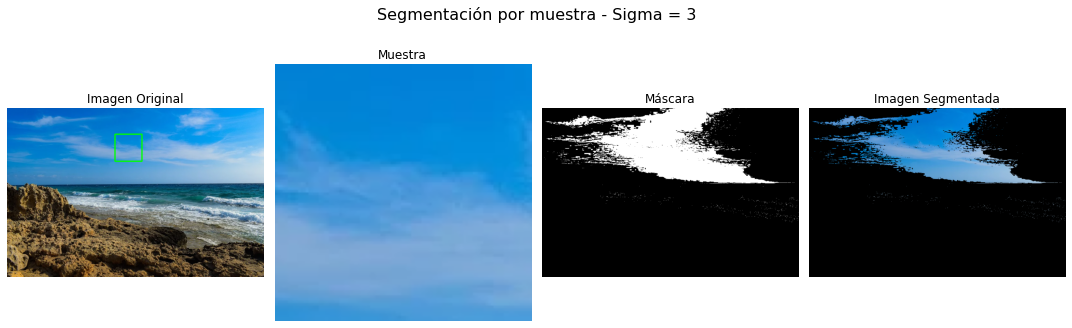

In [32]:
# Construir una mascara usando una muestra de la imagen
x1, y1, x2, y2 = 400, 100, 500, 200
img_muestra = img_seg[y1:y2, x1:x2,:]

color_mean, color_std = cv.meanStdDev(img_muestra)
n_sigma = 3
upper_lim = color_mean + n_sigma * color_std
lower_lim = color_mean - n_sigma * color_std
mask = cv.inRange(img_seg, lower_lim, upper_lim)
img_segmentada = cv.bitwise_and(img_seg, img_seg, mask=mask)

# Copiar imagen original y dibujar borde de la muestra
img_seg_cp = img_seg.copy()
cv.rectangle(img_seg_cp, (x1, y1), (x2, y2), (0, 255, 0), thickness=4)


fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(img_seg_cp[..., ::-1])
axs[0].axis('off')
axs[0].set_title("Imagen Original")
axs[1].imshow(img_muestra[..., ::-1])
axs[1].axis('off')
axs[1].set_title("Muestra")
axs[2].imshow(mask, cmap='gray')
axs[2].axis('off')
axs[2].set_title("Máscara")
axs[3].imshow(img_segmentada[..., ::-1])
axs[3].axis('off')
axs[3].set_title("Imagen Segmentada")
fig.set_tight_layout(True)
plt.suptitle("Segmentación por muestra - Sigma = {}".format(n_sigma), fontsize=16)
plt.savefig("segmentacion_muestra.png")
plt.show()

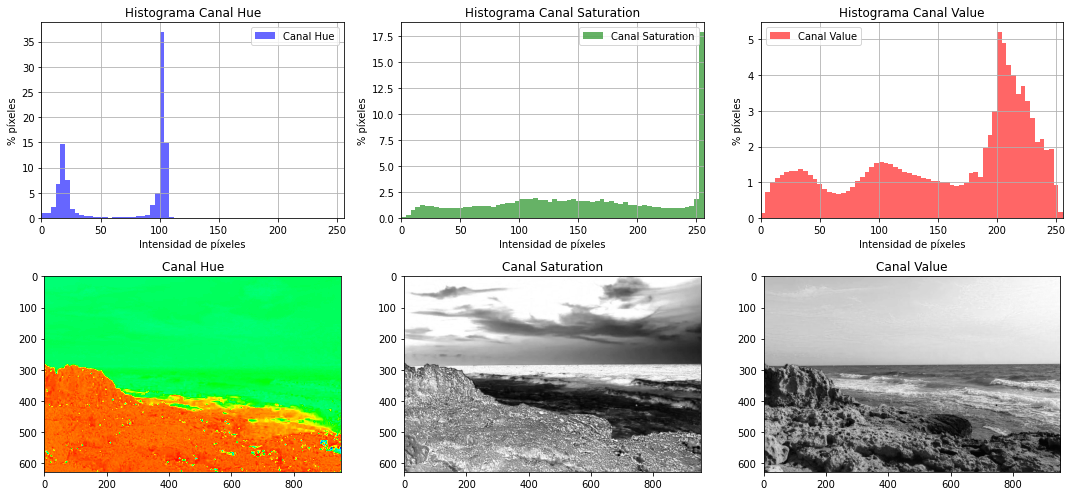

In [33]:
img_seg_hsv = cv.cvtColor(img_seg, cv.COLOR_BGR2HSV)

H, S, V = cv.split(img_seg_hsv)

n_bins = 64
bin_width = 256 // n_bins
bin_edges = np.arange(0, 256, bin_width)

hist_seg_H = cv.calcHist([H], [0], None, [n_bins], [0, 256], accumulate=False)
hist_seg_S = cv.calcHist([S], [0], None, [n_bins], [0, 256], accumulate=False)
hist_seg_V = cv.calcHist([V], [0], None, [n_bins], [0, 256], accumulate=False)

# normalize histograms
hist_seg_H = 100 * hist_seg_H / np.sum(hist_seg_H)
hist_seg_S = 100 * hist_seg_S / np.sum(hist_seg_S)
hist_seg_V = 100 * hist_seg_V / np.sum(hist_seg_V)

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

axs[0,0].bar(bin_edges, hist_seg_H[:, 0], width=bin_width, align='edge', color='b', alpha=0.6, label='Canal Hue')
axs[0,0].set_xlim([0, 256])
axs[0,0].set_title("Histograma Canal Hue")
axs[0,0].set_xlabel("Intensidad de píxeles")
axs[0,0].set_ylabel("% píxeles")
axs[0,0].legend()
axs[0,0].grid()

axs[0,1].bar(bin_edges, hist_seg_S[:, 0], width=bin_width, align='edge', color='g', alpha=0.6, label='Canal Saturation')
axs[0,1].set_xlim([0, 256])
axs[0,1].set_title("Histograma Canal Saturation")
axs[0,1].set_xlabel("Intensidad de píxeles")
axs[0,1].set_ylabel("% píxeles")
axs[0,1].legend()
axs[0,1].grid()

axs[0,2].bar(bin_edges, hist_seg_V[:, 0], width=bin_width, align='edge', color='r', alpha=0.6, label='Canal Value')
axs[0,2].set_xlim([0, 256])
axs[0,2].set_title("Histograma Canal Value")
axs[0,2].set_xlabel("Intensidad de píxeles")
axs[0,2].set_ylabel("% píxeles")
axs[0,2].legend()
axs[0,2].grid()

axs[1,0].imshow(H, cmap='hsv', vmin=0, vmax=255)
axs[1,0].set_title("Canal Hue")
axs[1,1].imshow(S, cmap='gray', vmin=0, vmax=255)
axs[1,1].set_title("Canal Saturation")
axs[1,2].imshow(V, cmap='gray', vmin=0, vmax=255)
axs[1,2].set_title("Canal Value")

fig.set_tight_layout(True)
plt.savefig("histograma_hsv_segmentacion.png")
plt.show()

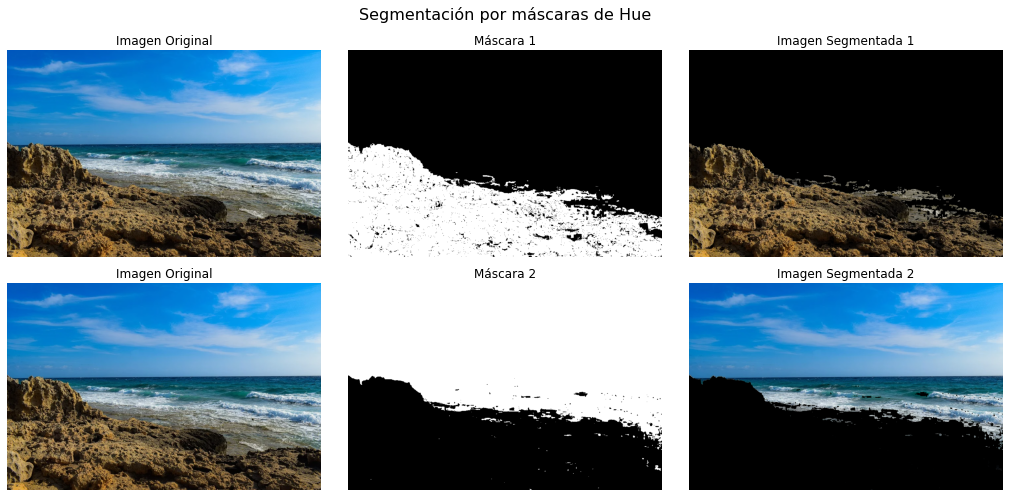

In [34]:
# Mascara con los picos de H
masks_H = []
peaks, _ = find_peaks(hist_seg_H.flatten(), height=5)
peaks = peaks * 4
n_peaks = len(peaks)

for peak in peaks:
    upper_lim, lower_lim = int(peak + 10), int(peak - 10)
    mask = cv.inRange(H, lower_lim, upper_lim)
    masks_H.append(mask)

fig, axs = plt.subplots(n_peaks, 3, figsize=(15, 7))
for i, mask in enumerate(masks_H):
    img_segmentada = cv.bitwise_and(img_seg, img_seg, mask=mask)
    axs[i,0].imshow(img_seg[..., ::-1])
    axs[i,0].axis('off')
    axs[i,0].set_title("Imagen Original")
    axs[i,1].imshow(mask, cmap='gray')
    axs[i,1].axis('off')
    axs[i,1].set_title("Máscara {}".format(i+1))
    axs[i,2].imshow(img_segmentada[..., ::-1])
    axs[i,2].axis('off')
    axs[i,2].set_title("Imagen Segmentada {}".format(i+1))
fig.set_tight_layout(True)
plt.suptitle("Segmentación por máscaras de Hue", fontsize=16)
plt.savefig("segmentacion_hue.png")
plt.show()

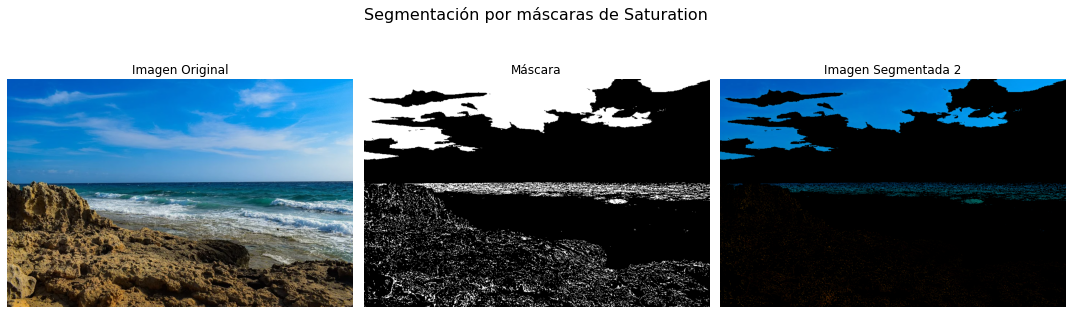

In [35]:
# Mascara con los picos de S
peak_S = int(bin_width * np.argmax(hist_seg_S))
upper_lim, lower_lim = int(peak_S + 10), int(peak_S - 10)
mask_S = cv.inRange(S, lower_lim, upper_lim)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
img_segmentada = cv.bitwise_and(img_seg, img_seg, mask=mask_S)
axs[0].imshow(img_seg[..., ::-1])
axs[0].axis('off')
axs[0].set_title("Imagen Original")
axs[1].imshow(mask_S, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Máscara")
axs[2].imshow(img_segmentada[..., ::-1])
axs[2].axis('off')
axs[2].set_title("Imagen Segmentada {}".format(i+1))
fig.set_tight_layout(True)
plt.suptitle("Segmentación por máscaras de Saturation", fontsize=16)
plt.savefig("segmentacion_saturation.png")
plt.show()

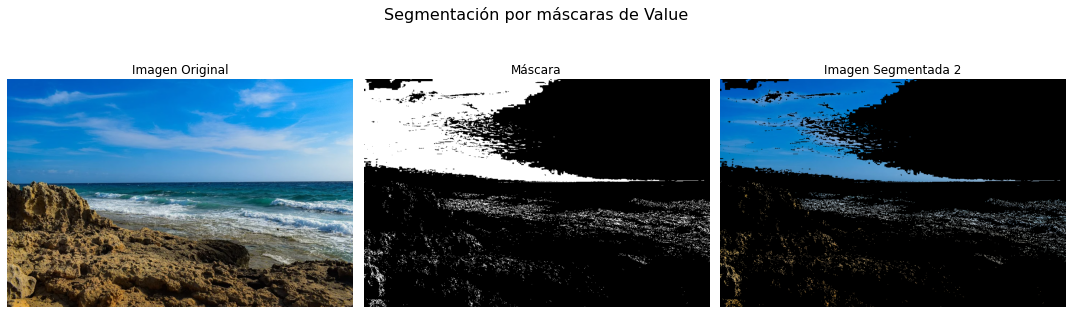

In [36]:
# Mascara con los picos de V
peak_V = int(bin_width * np.argmax(hist_seg_V))
upper_lim, lower_lim = int(peak_V + 10), int(peak_V - 10)
mask_V = cv.inRange(V, lower_lim, upper_lim)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
img_segmentada = cv.bitwise_and(img_seg, img_seg, mask=mask_V)
axs[0].imshow(img_seg[..., ::-1])
axs[0].axis('off')
axs[0].set_title("Imagen Original")
axs[1].imshow(mask_V, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Máscara")
axs[2].imshow(img_segmentada[..., ::-1])
axs[2].axis('off')
axs[2].set_title("Imagen Segmentada {}".format(i+1))
fig.set_tight_layout(True)
plt.suptitle("Segmentación por máscaras de Value", fontsize=16)
plt.savefig("segmentacion_value.png")
plt.show()